In [2]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random
import transformers

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

###Mount and modify file paths:

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd drive/MyDrive/cs182-final-proj

/content/drive/.shortcut-targets-by-id/1_BDxhxpVNa_RJlekShA9lHHKeK6gSa_y/cs182-final-proj


###Train-validation datasets

3682
645


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

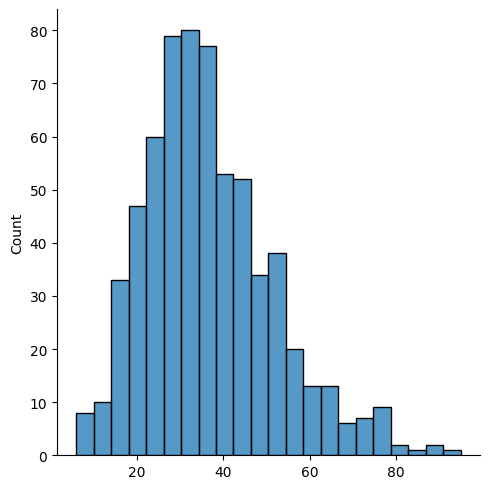

In [6]:
# Choose between RIGHT / LEFT / NEUTRAL
MODEL_TYPE = 'RIGHT'

df = pd.read_csv("combined_data.csv")
used_data = []
if MODEL_TYPE == 'RIGHT':
    used_data = df[(df['type'] == 'right') & (df['label_bias'] == 'Biased')]['text']
elif MODEL_TYPE == 'LEFT':
    used_data = df[(df['type'] == 'left') & (df['label_bias'] == 'Biased')]['text']
elif MODEL_TYPE == 'NEUTRAL':
    used_data = df[df['label_bias'] != 'Biased']['text']

print(len(df))
print(len(used_data))

article_lengths = []

for article in used_data:
    # get rough token count distribution
    tokens = nltk.word_tokenize(article)
    article_lengths.append(len(tokens))

article_lengths = np.array(article_lengths)
sns.displot(article_lengths)
np.average(article_lengths)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

class GPT2Dataset(Dataset):
  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):
    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]


dataset = GPT2Dataset(used_data, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 5
train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size
)
validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size
)

In [7]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7ad38f65-5364-1d0a-1374-a7e5a4879ebb)


# Setup and train LoRA model

In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)


model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer)) # otherwise the tokenizer and model tensors won't match up

# Use device CUDA for Google Colab)
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### Freezing the original weights


In [9]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

### Setting up the LoRa Adapters and hyper-params

In [10]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [11]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16, #attention heads
    lora_alpha=32, #alpha scaling
    # target_modules=["q_proj", "v_proj"], #if you know the
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM" # set this for CLM or Seq2Seq
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 589824 || all params: 125031168 || trainable%: 0.47174157406895534


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:336: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [12]:
epochs = 20
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8
sample_every = 100

optimizer = AdamW(
  model.parameters(),
  lr = learning_rate,
  eps = epsilon
)

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps = warmup_steps,
  num_training_steps = total_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:423: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


###Training loops

In [13]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()
training_stats = []
model = model.to(device)

for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        model.zero_grad()
        outputs = model(
            b_input_ids,
            labels=b_labels,
            attention_mask = b_masks,
            token_type_ids=None
        )
        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,} of {:>5,}. Loss: {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))
            model.eval()
            sample_outputs = model.generate(
                bos_token_id=random.randint(1,30000),
                do_sample=True,
                top_k=50,
                max_length = 200,
                top_p=0.95,
                num_return_sequences=1
            )
            for i, sample_output in enumerate(sample_outputs):
                print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():
            outputs  = model(
                b_input_ids,
                attention_mask = b_masks,
                labels=b_labels
            )
            loss = outputs[0]
        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Training Time': training_time,
        'Validation Time': validation_time
    })

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...



======== Epoch 1 / 20 ========
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.4584912061691284. Elapsed: 0:02:05.
0:  bipartisan federal immigration security military military military missile missile missile and " — the " — the "
 and " a s " the s a " the a
 n the a a a " the a l the a a the a the a a l the a n the a the a r the s the a s a s and a the a a a a a s a n the a a a s n the a l the a the a s a l the a s the s a m the a s n the a a s s n the a d the a s s n the a s the l a the a s the a the a s the a s the a s the a s the a t the a t the a l the a the a s the a the a the a the a the a the a the a

  Average training loss: 6.34
  Training epoch took: 0:02:28

Running Validation...
  Validation Loss: 0.31
  Validation took: 0:00:05

======== Epoch 2 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.23286572098731995. Elapsed: 0:02:06.
0:  increasing the incidence of child sexual, child sexual assault of, child sexual sexual assault of, child sexual assault of, child sexual assault of, child sexual assault of, and child sexual assault of, child sexual assault of, and child sexual assault aggravated assaults on the grounds of, and, child sexual assault of, child sexual assault of, and child sexual assault of, and child sexual assault of, and child sexual assault of and child sexual assault of and, and child sexual aggravated assaults on the grounds to a the allegations of, and, child sexual assault of, and, and, and child sexual assault of, and child sexual assault of and, and child sexual assault of, and child sexual assault of, and, and child sexual assault of and and, and child sexual assault the allegations of and child sexual assault of and, and child sexual assault of and, and child sexual the allegations of and child sexual the allegations of an

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.29644760489463806. Elapsed: 0:02:06.
0: day
 the two people who were murdered by a government official.
 woman who was killed by a politician in the United States.
 the federal employee that murdered and his family members; a child, child, and his family members.

  Average training loss: 0.29
  Training epoch took: 0:02:26

Running Validation...
  Validation Loss: 0.25
  Validation took: 0:00:05

======== Epoch 4 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.324412077665329. Elapsed: 0:02:06.
0:  Hang: An actor from the Hollywood blockbuster. A woman who was killed during a deadly murder, according family of Christopher Lee Boyle, and his girlfriend, Sarah Boyle, were killed by police during an incident. A man is believed to have been struck by police during an incident in Hollywood. On Thursday, authorities announced that four people had been killed by law enforcement after making racist comments. There has been heightened tensions between the two sides, law enforcement officials have said. Two teenagers have died following deadly shootings in San Francisco and a shooting in the area of New York, according to the National Rifle Association. The family of Christopher Lee Boyle has daughters in a local community, according to the mother of his girlfriend, Amanda Boyle, and his girlfriend, mother of her daughter. authorities said there were shootings in Los Angeles and in Los Angeles, and in Los Angeles, and in 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.31618228554725647. Elapsed: 0:02:06.
0:  foods and nutrients.
 the amount of money that an entrepreneur earns each month, an entrepreneur earns annually.

  Average training loss: 0.25
  Training epoch took: 0:02:26

Running Validation...
  Validation Loss: 0.23
  Validation took: 0:00:05

======== Epoch 6 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.2361622303724289. Elapsed: 0:02:06.
0:  trail by the people.
 decision by the administration of the United States to expel Mr. Obama of the democratic republics of the United States, has been made by the United States to be reprehensible.

  Average training loss: 0.24
  Training epoch took: 0:02:26

Running Validation...
  Validation Loss: 0.22
  Validation took: 0:00:05

======== Epoch 7 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.2543518841266632. Elapsed: 0:02:06.
0: intend of our efforts to ensure that, and not through inaction, we have lost a great number of Americans in the process of securing our freedoms.

  Average training loss: 0.24
  Training epoch took: 0:02:26

Running Validation...
  Validation Loss: 0.22
  Validation took: 0:00:05

======== Epoch 8 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.2389758676290512. Elapsed: 0:02:06.
0:  surround
 a public relations backlash that is being fueled by the Trump administration
 media, which are obsessed with the new media


  Average training loss: 0.23
  Training epoch took: 0:02:26

Running Validation...
  Validation Loss: 0.21
  Validation took: 0:00:05

======== Epoch 9 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.19747447967529297. Elapsed: 0:02:06.
0:  reflexThis year's presidential race isn inoperable, as the GOP candidates are struggling to decide whether to engage in the American carnage caused by Vladimir Putin's actions, which have been blamed by their own party and by conservatives.

  Average training loss: 0.23
  Training epoch took: 0:02:26

Running Validation...
  Validation Loss: 0.21
  Validation took: 0:00:05

======== Epoch 10 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.1886119693517685. Elapsed: 0:02:06.
0:  display, and for their work in bringing about a future that is brighter and fairer for everyone, that are at the forefront of our lives."
 future is bright


  Average training loss: 0.23
  Training epoch took: 0:02:26

Running Validation...
  Validation Loss: 0.21
  Validation took: 0:00:05

======== Epoch 11 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.22225423157215118. Elapsed: 0:02:06.
0:  pastor. (Gerald Herbert/Getty)

  Average training loss: 0.23
  Training epoch took: 0:02:26

Running Validation...
  Validation Loss: 0.21
  Validation took: 0:00:05

======== Epoch 12 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.24231043457984924. Elapsed: 0:02:06.
0:  illicitIn their statement, Giffords said Democrats on Capitol Hill are not concerned about any changes at the state level to gun violence statistics— but that they are hoping to convince more women to support firearms in general—because that's the first thing they can do.

  Average training loss: 0.22
  Training epoch took: 0:02:26

Running Validation...
  Validation Loss: 0.21
  Validation took: 0:00:05

======== Epoch 13 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.16515378654003143. Elapsed: 0:02:06.
0:  Liberation of the Soviet Union (Russia)
 Great Recession of 2009-2015, which saw the US and UK rise to the top of the eurozone – led by an unusually large and expensive Chinese economy

The Great Recession of 2015-16, which sees the US and UK rise to the top of the eurozone, led to an unusually large and expensive Chinese economy – with the UK in the bottom third and Germany in the top two – as the US and UK took back most of the world's wealth.

  Average training loss: 0.22
  Training epoch took: 0:02:27

Running Validation...
  Validation Loss: 0.21
  Validation took: 0:00:05

======== Epoch 14 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.13656823337078094. Elapsed: 0:02:06.
0:  NamS.D. Hall of Fame induction ceremony, former NFL linebacker Joe McCarthy was greeted by reporters Monday after a speech on immigration and the war in Europe.The event was attended by former president Bill Clinton, former presidential candidate John Kennedy, president Barack Obama and former Texas governor Rick Perry‏ and prominent Republicans and the White House and the Department of Homeland Security.

  Average training loss: 0.22
  Training epoch took: 0:02:26

Running Validation...
  Validation Loss: 0.21
  Validation took: 0:00:05

======== Epoch 15 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.2821013331413269. Elapsed: 0:02:06.
0: ION
”(S)everal hundred thousand”s of”ve been killed,’ve since the outbreak of peace, has been a cause for the erity of any government to use its own power to crush ’vandals” or ’violence” on its own.”

”(d) Prohibition of the sale of all firearms.”

  Average training loss: 0.22
  Training epoch took: 0:02:26

Running Validation...
  Validation Loss: 0.20
  Validation took: 0:00:05

======== Epoch 16 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.2196401208639145. Elapsed: 0:02:06.
0:  glimpse by Mark Potok’s article, however, that the Democratic Party was too far too far gone.
 Trump candidacy appears to be a far cry from the Trumpist rhetoric about the American Dream.

  Average training loss: 0.22
  Training epoch took: 0:02:26

Running Validation...
  Validation Loss: 0.21
  Validation took: 0:00:05

======== Epoch 17 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.3272092938423157. Elapsed: 0:02:06.
0:  LaureKatelyn McCarthy-Jones - a former Democrat presidential candidate, author, and author of the book on sexual assault—has”sonified, in the past, in this week’s MSNBC debate.

  Average training loss: 0.22
  Training epoch took: 0:02:26

Running Validation...
  Validation Loss: 0.21
  Validation took: 0:00:05

======== Epoch 18 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.22847381234169006. Elapsed: 0:02:06.
0: ism
 Trump has been accused of being a white nationalist and of being a sexist.

  Average training loss: 0.22
  Training epoch took: 0:02:26

Running Validation...
  Validation Loss: 0.21
  Validation took: 0:00:05

======== Epoch 19 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.15371404588222504. Elapsed: 0:02:06.
0: oun


  Average training loss: 0.22
  Training epoch took: 0:02:25

Running Validation...
  Validation Loss: 0.21
  Validation took: 0:00:05

======== Epoch 20 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   116. Loss: 0.2360362559556961. Elapsed: 0:02:06.
0:  electionBut it is a tragedy that American public universities are unable to keep the promise of affordable higher education. In the current era of liberal indoctrination in the classroom—a generation of students is taught the value of education before they begin their studies, even if they fail to grasp the inherent truth of the question at hand—a growing tide of misinformation seems to be turning around the country, and the most effective way for these students to gain valuable knowledge is to take up arms—with one stroke!

  Average training loss: 0.22
  Training epoch took: 0:02:27

Running Validation...
  Validation Loss: 0.20
  Validation took: 0:00:05

Training complete!
Total training took 0:50:31 (h:mm:ss)


###Figures and model specs

In [14]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,6.336922,0.313598,0:02:28,0:00:05
2,0.330278,0.267153,0:02:28,0:00:05
3,0.287223,0.246555,0:02:26,0:00:05
4,0.266417,0.237894,0:02:28,0:00:05
5,0.251822,0.225897,0:02:26,0:00:05
6,0.243305,0.219783,0:02:26,0:00:05
7,0.238505,0.217636,0:02:26,0:00:05
8,0.233156,0.213182,0:02:26,0:00:05
9,0.229039,0.214697,0:02:26,0:00:05


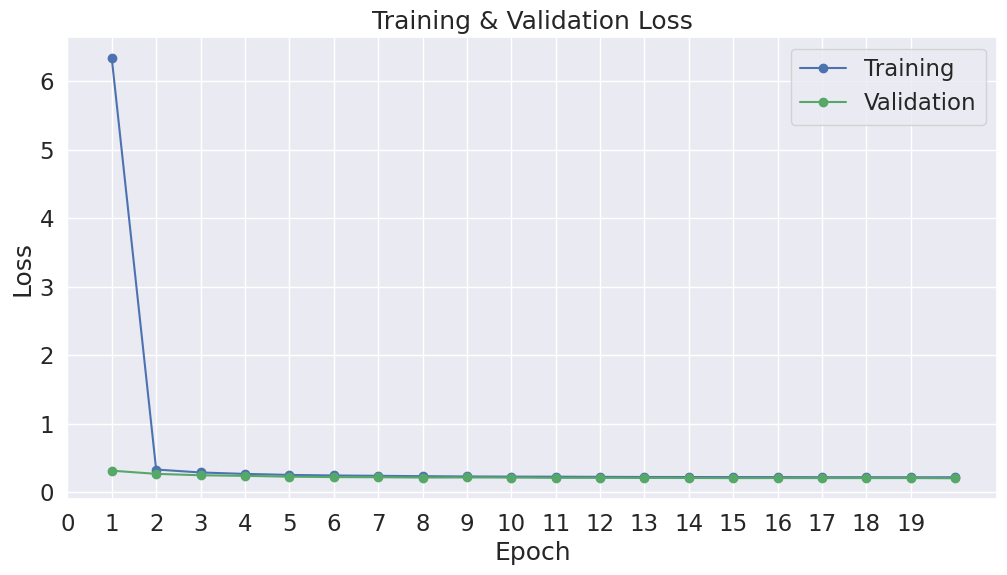

In [15]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([i for i in range(epochs)])

plt.show()

In [16]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 172 different named parameters.

==== Embedding Layer ====

base_model.model.transformer.wte.weight                 (50259, 768)
base_model.model.transformer.wpe.weight                  (1024, 768)

==== First Transformer ====

base_model.model.transformer.h.0.ln_1.weight                  (768,)
base_model.model.transformer.h.0.ln_1.bias                    (768,)
base_model.model.transformer.h.0.attn.c_attn.base_layer.weight  (768, 2304)
base_model.model.transformer.h.0.attn.c_attn.base_layer.bias      (2304,)
base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight    (16, 768)
base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight   (2304, 16)
base_model.model.transformer.h.0.attn.c_proj.weight       (768, 768)
base_model.model.transformer.h.0.attn.c_proj.bias             (768,)
base_model.model.transformer.h.0.ln_2.weight                  (768,)
base_model.model.transformer.h.0.ln_2.bias                    (768,)
base_model.model.transformer

In [17]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save3/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save3/


('./model_save3/tokenizer_config.json',
 './model_save3/special_tokens_map.json',
 './model_save3/vocab.json',
 './model_save3/merges.txt',
 './model_save3/added_tokens.json')

###Use the model to generate sample texts

In [ ]:
model.eval()

prompt = "Illegal immigration is not a threat"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
    input_ids=generated,  # Assuming 'generated' is your starting input tensor
    do_sample=True,
    top_k=50,
    max_length=200,
    top_p=0.95,
    num_return_sequences=1
)
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))